# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import folium
import pandas as pd
import numpy as np
import io
from PIL import Image
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# 1.0 Import Data

## 1.1 Toronto Bike Share 2019 Ridership Data

In [3]:
# Import ridership data
data_dir = '/content/drive/My Drive/MIE498 Thesis/0_Data'
merged_bike_data_2019 = pd.read_csv("{}/ridership_2019_with_bike_stations_info_20200930.csv".format(data_dir), header=0)
print(merged_bike_data_2019.shape)
merged_bike_data_2019['End Day of Year'] = merged_bike_data_2019.apply(lambda row: datetime.strptime(row['End Time'], "%Y-%m-%d %H:%M:%S").timetuple().tm_yday, axis=1)
print(merged_bike_data_2019.shape)
merged_bike_data_2019.head()

(2438720, 26)
(2438720, 27)


,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type,Bike Id,...,End Hour,End Day of Week,End Holiday,Start Day of Year,Start Week of Year,Start Lat,Start Lon,End Lat,End Lon,End Day of Year
0,4581278.0,1547.0,7021.0,2019-01-01 00:08:00,Bay St / Albert St,7233.0,2019-01-01 00:33:00,King / Cowan Ave - SMART,Annual Member,1296.0,...,0.0,1.0,1.0,1.0,1.0,43.653264,-79.382458,43.637922,-79.431734,1
1,4586979.0,1243.0,7021.0,2019-01-03 17:13:00,Bay St / Albert St,7233.0,2019-01-03 17:34:00,King / Cowan Ave - SMART,Annual Member,3168.0,...,17.0,3.0,0.0,3.0,1.0,43.653264,-79.382458,43.637922,-79.431734,3
2,4591641.0,1112.0,7021.0,2019-01-04 21:42:00,Bay St / Albert St,7233.0,2019-01-04 22:00:00,King / Cowan Ave - SMART,Annual Member,3512.0,...,22.0,4.0,0.0,4.0,1.0,43.653264,-79.382458,43.637922,-79.431734,4
3,4594328.0,1156.0,7021.0,2019-01-05 23:21:00,Bay St / Albert St,7233.0,2019-01-05 23:40:00,King / Cowan Ave - SMART,Annual Member,212.0,...,23.0,5.0,0.0,5.0,1.0,43.653264,-79.382458,43.637922,-79.431734,5
4,4596322.0,1068.0,7021.0,2019-01-06 21:42:00,Bay St / Albert St,7233.0,2019-01-06 22:00:00,King / Cowan Ave - SMART,Annual Member,3279.0,...,22.0,6.0,0.0,6.0,1.0,43.653264,-79.382458,43.637922,-79.431734,6


## 1.2 Bike Station 2019 - Neighbourhood, FSA, and DA Assignments

In [4]:
# Read station-neighbourhood mapping
df_station_assignments = pd.read_csv("{}/station_assignment.csv".format(data_dir), header=0, encoding='ISO-8859-1')
print(df_station_assignments.shape)
print(df_station_assignments.columns)
df_station_assignments.head()

(464, 7)
Index(['station_id', 'station_na', 'lat', 'lon', 'neighborhood_id', 'FSA_code',
       'da_id'],
      dtype='object')


,station_id,station_na,lat,lon,neighborhood_id,FSA_code,da_id
0,7021,Bay St / Albert St,43.653264,-79.382458,76,M5G,35204616.0
1,7160,King St W / Tecumseth St,43.643333,-79.405556,82,M5V,35204142.0
2,7012,Elizabeth St / Edward St (Bus Terminal),43.656026,-79.385327,76,M5G,35204607.0
3,7041,Edward St / Yonge St,43.656729,-79.382736,76,M5G,35204608.0
4,7275,Queen St W / James St,43.652276,-79.380701,76,M5G,35204616.0


In [5]:
# create station dictionaries
station_neigh_dict = pd.Series(df_station_assignments['neighborhood_id'].values, index=df_station_assignments['station_id']).to_dict()
station_fsa_dict = pd.Series(df_station_assignments['FSA_code'].values, index=df_station_assignments['station_id']).to_dict()
station_da_dict = pd.Series(df_station_assignments['da_id'].values, index=df_station_assignments['station_id']).to_dict()

In [6]:
# Get Columns of Data
merged_bike_data_2019.columns

Index(['Trip Id', 'Trip Duration', 'Start Station Id', 'Start Time',
       'Start Station Name', 'End Station Id', 'End Time', 'End Station Name',
       'User Type', 'Bike Id', 'Start Year', 'Start Month', 'Start Hour',
       'Start Day of Week', 'Start Holiday', 'End Year', 'End Month',
       'End Hour', 'End Day of Week', 'End Holiday', 'Start Day of Year',
       'Start Week of Year', 'Start Lat', 'Start Lon', 'End Lat', 'End Lon',
       'End Day of Year'],
      dtype='object')

## 1.4 Heatmap Data

In [7]:
heatmap_data = merged_bike_data_2019[['Trip Id', 'Start Station Id', 'Start Station Name', 'Start Day of Week', 'Start Month', 'Start Hour', 'Start Holiday', 'Start Day of Year', 'End Station Id', 'End Station Name', 'User Type']]

print(heatmap_data.shape)
# heatmap_data['Start Neighbourhood'] = heatmap_data.apply(lambda row: station_neigh_dict[int(row['Start Station Id'])], axis=1)
# heatmap_data['End Neighbourhood'] = heatmap_data.apply(lambda row: station_neigh_dict[int(row['End Station Id'])], axis=1)

heatmap_data['Start Forward_Sortation_Area'] = heatmap_data.apply(lambda row: station_fsa_dict[int(row['Start Station Id'])], axis=1)
heatmap_data['End Forward_Sortation_Area'] = heatmap_data.apply(lambda row: station_fsa_dict[int(row['End Station Id'])], axis=1)

heatmap_data['Start Dissemination_Area'] = heatmap_data.apply(lambda row: station_da_dict[int(row['Start Station Id'])], axis=1)
heatmap_data['End Dissemination_Area'] = heatmap_data.apply(lambda row: station_da_dict[int(row['End Station Id'])], axis=1)

print(heatmap_data.shape)
heatmap_data.dropna(inplace=True)
print(heatmap_data.shape)

heatmap_data['Start Dissemination_Area'] = heatmap_data['Start Dissemination_Area'].astype("int64").astype("string")
heatmap_data['End Dissemination_Area'] = heatmap_data['End Dissemination_Area'].astype("int64").astype("string")
print(heatmap_data.dtypes)

heatmap_data.head()

(2438720, 11)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

(2438720, 15)


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(2418266, 15)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trip Id                         float64
Start Station Id                float64
Start Station Name               object
Start Day of Week               float64
Start Month                     float64
Start Hour                      float64
Start Holiday                   float64
Start Day of Year               float64
End Station Id                  float64
End Station Name                 object
User Type                        object
Start Forward_Sortation_Area     object
End Forward_Sortation_Area       object
Start Dissemination_Area         string
End Dissemination_Area           string
dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Trip Id,Start Station Id,Start Station Name,Start Day of Week,Start Month,Start Hour,Start Holiday,Start Day of Year,End Station Id,End Station Name,User Type,Start Forward_Sortation_Area,End Forward_Sortation_Area,Start Dissemination_Area,End Dissemination_Area
0,4581278.0,7021.0,Bay St / Albert St,1.0,1.0,0.0,1.0,1.0,7233.0,King / Cowan Ave - SMART,Annual Member,M5G,M6K,35204616,35203170
1,4586979.0,7021.0,Bay St / Albert St,3.0,1.0,17.0,0.0,3.0,7233.0,King / Cowan Ave - SMART,Annual Member,M5G,M6K,35204616,35203170
2,4591641.0,7021.0,Bay St / Albert St,4.0,1.0,21.0,0.0,4.0,7233.0,King / Cowan Ave - SMART,Annual Member,M5G,M6K,35204616,35203170
3,4594328.0,7021.0,Bay St / Albert St,5.0,1.0,23.0,0.0,5.0,7233.0,King / Cowan Ave - SMART,Annual Member,M5G,M6K,35204616,35203170
4,4596322.0,7021.0,Bay St / Albert St,6.0,1.0,21.0,0.0,6.0,7233.0,King / Cowan Ave - SMART,Annual Member,M5G,M6K,35204616,35203170


# 3.0 Transition Matrix Heatmap

## 3.1 Function Definitions & Data Splitting

In [8]:
def split_weekday_weekend_transition_matrix(df):
  filter_weekday = (df['Start Day of Week'] >= 0) & (df['Start Day of Week'] <= 4)
  filter_weekend = (df['Start Day of Week'] == 5) | (df['Start Day of Week'] == 6)
  df_weekday, df_weekend = df.loc[filter_weekday], df.loc[filter_weekend]
  return df_weekday, df_weekend

In [9]:
def split_hours_transition_matrix(df, hour):
  return df.loc[(df['Start Hour'] == hour)]

In [10]:
heatmap_weekday, heatmap_weekend = split_weekday_weekend_transition_matrix(heatmap_data)

In [11]:
heatmap_hours_list = []
count = 0
for i in range(0, 24):
  heatmap_temp = split_hours_transition_matrix(heatmap_data, i)
  count += len(heatmap_temp)
  heatmap_hours_list.append(heatmap_temp)

In [12]:
def compute_heatmap(df_season, region_division, hm_size):
  unique_start = list(np.unique(df_season['Start {}'.format(region_division)]))  
  df_season_pivoted = pd.DataFrame(data=np.zeros((hm_size, hm_size)), columns = unique_start, index=unique_start)
  df_season_pivoted = df_season_pivoted.astype("int")
  
  num_days = len(np.unique(df_season['Start Day of Year']))

  # for each Start Station
  for start_n in unique_start:
    df_start_neigh = df_season[df_season['Start {}'.format(region_division)] == start_n]
    df_counts = pd.DataFrame(df_start_neigh['End {}'.format(region_division)].value_counts())
    df_counts.rename(columns={f'End {region_division}': 'Average Number of Trips'}, inplace=True)
    df_counts['Average Number of Trips'] = df_counts['Average Number of Trips'].div(num_days)
    
    # print(df_counts.head())
    region_list = list(df_counts.index)
    
    for end_n in region_list:
      cnt = df_counts.loc[end_n]['Average Number of Trips']
      df_season_pivoted.loc[start_n, end_n] = cnt
  
  df_season_pivoted = df_season_pivoted.div(df_season_pivoted.sum(axis=1), axis=0)
  return df_season_pivoted

In [13]:
def plot_heatmap(hm_matrix, plot_name, figure_size=(10, 8)):
  fig = plt.figure(figsize=figure_size)
  sns.heatmap(hm_matrix, cmap='PuBuGn', vmin=0, vmax=0.6)  # tab20c, twilight, coolwarm vmin, vmax
  fig.savefig(f'{plot_name}.png')
  plt.show()

In [18]:
def plot_24_heatmaps(hm_matrix, plot_name, figure_size=(40, 25)):
  # f,(ax1,ax2,ax3,ax4,ax5,ax6, axcb) = plt.subplots(1,7, gridspec_kw={'width_ratios':[1,1,1,1,1,1,0.08]}, figsize=figure_size)
  f,((ax1,ax2,ax3,ax4,ax5,ax6),(ax7,ax8,ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16,ax17,ax18),(ax19,ax20,ax21,ax22,ax23,ax24)) = plt.subplots(4,6, sharex=True, sharey=True, figsize=figure_size)
  ax1.get_shared_y_axes().join(ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21,ax22,ax23,ax24)
  
  ax_list = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21,ax22,ax23,ax24]
  g1 = sns.heatmap(hm_matrix[0],cmap="PuBuGn",cbar=True,ax=ax1)
  g1.set_ylabel('')
  g1.set_xlabel('')
  ax_list[0].set_title('Hour {}'.format(0), fontsize=18)
  g_list = [g1]
  
  for i in range(1,24):
    g = sns.heatmap(hm_matrix[i],cmap="PuBuGn",cbar=True,ax=ax_list[i], vmin=0, vmax=1)
    g.set_ylabel('')
    g.set_xlabel('')
    ax_list[i].set_title('Hour {}'.format(i), fontsize=18)
    # g.set_yticks([])
    g_list.append(g)
  # g2 = sns.heatmap(hm_matrix[1],cmap="YlGnBu",cbar=False,ax=ax2)
  # g2.set_ylabel('')
  # g2.set_xlabel('')
  # g2.set_yticks([])
  # g3 = sns.heatmap(flights,cmap="YlGnBu",ax=ax3, cbar_ax=axcb)
  # g3.set_ylabel('')
  # g3.set_xlabel('')
  # g3.set_yticks([])

  # may be needed to rotate the ticklabels correctly:
  # for ax in g_list:
  #     tl = ax.get_xticklabels()
  #     ax.set_xticklabels(tl, rotation=90)
  #     tly = ax.get_yticklabels()
  #     ax.set_yticklabels(tly, rotation=0)
  f.savefig(f'{plot_name}.png')
  plt.show()


## 3.2 Weekday / Weekend

Forward Sortation Area


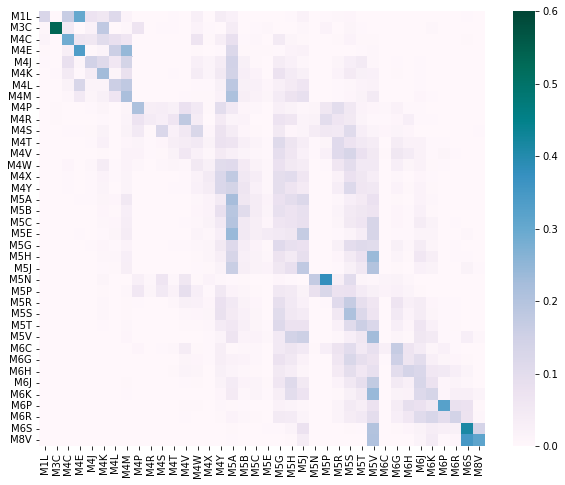

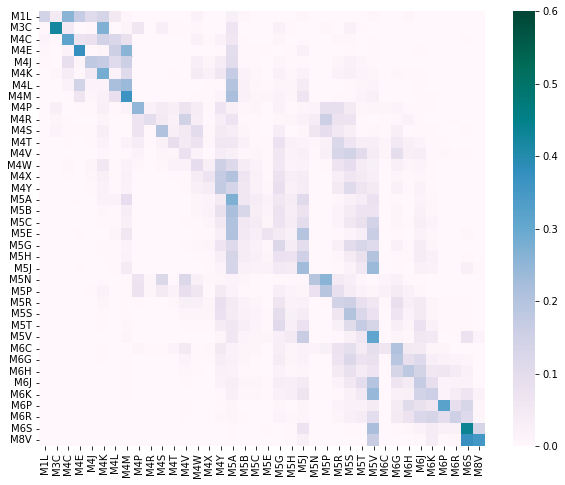

In [15]:
print('Forward Sortation Area')
heatmap_matrix = compute_heatmap(heatmap_weekday, 'Forward_Sortation_Area', 38)
# print('Max Value: ', heatmap_matrix.to_numpy().max())
# display(heatmap_matrix)
plot_heatmap(heatmap_matrix, 'Forward_Sortation_Area_Weekday')

heatmap_matrix = compute_heatmap(heatmap_weekend, 'Forward_Sortation_Area', 38)
plot_heatmap(heatmap_matrix, 'Forward_Sortation_Area_Weekend')

## 3.3 By Hour

Forward Sortation Area_24_Hours


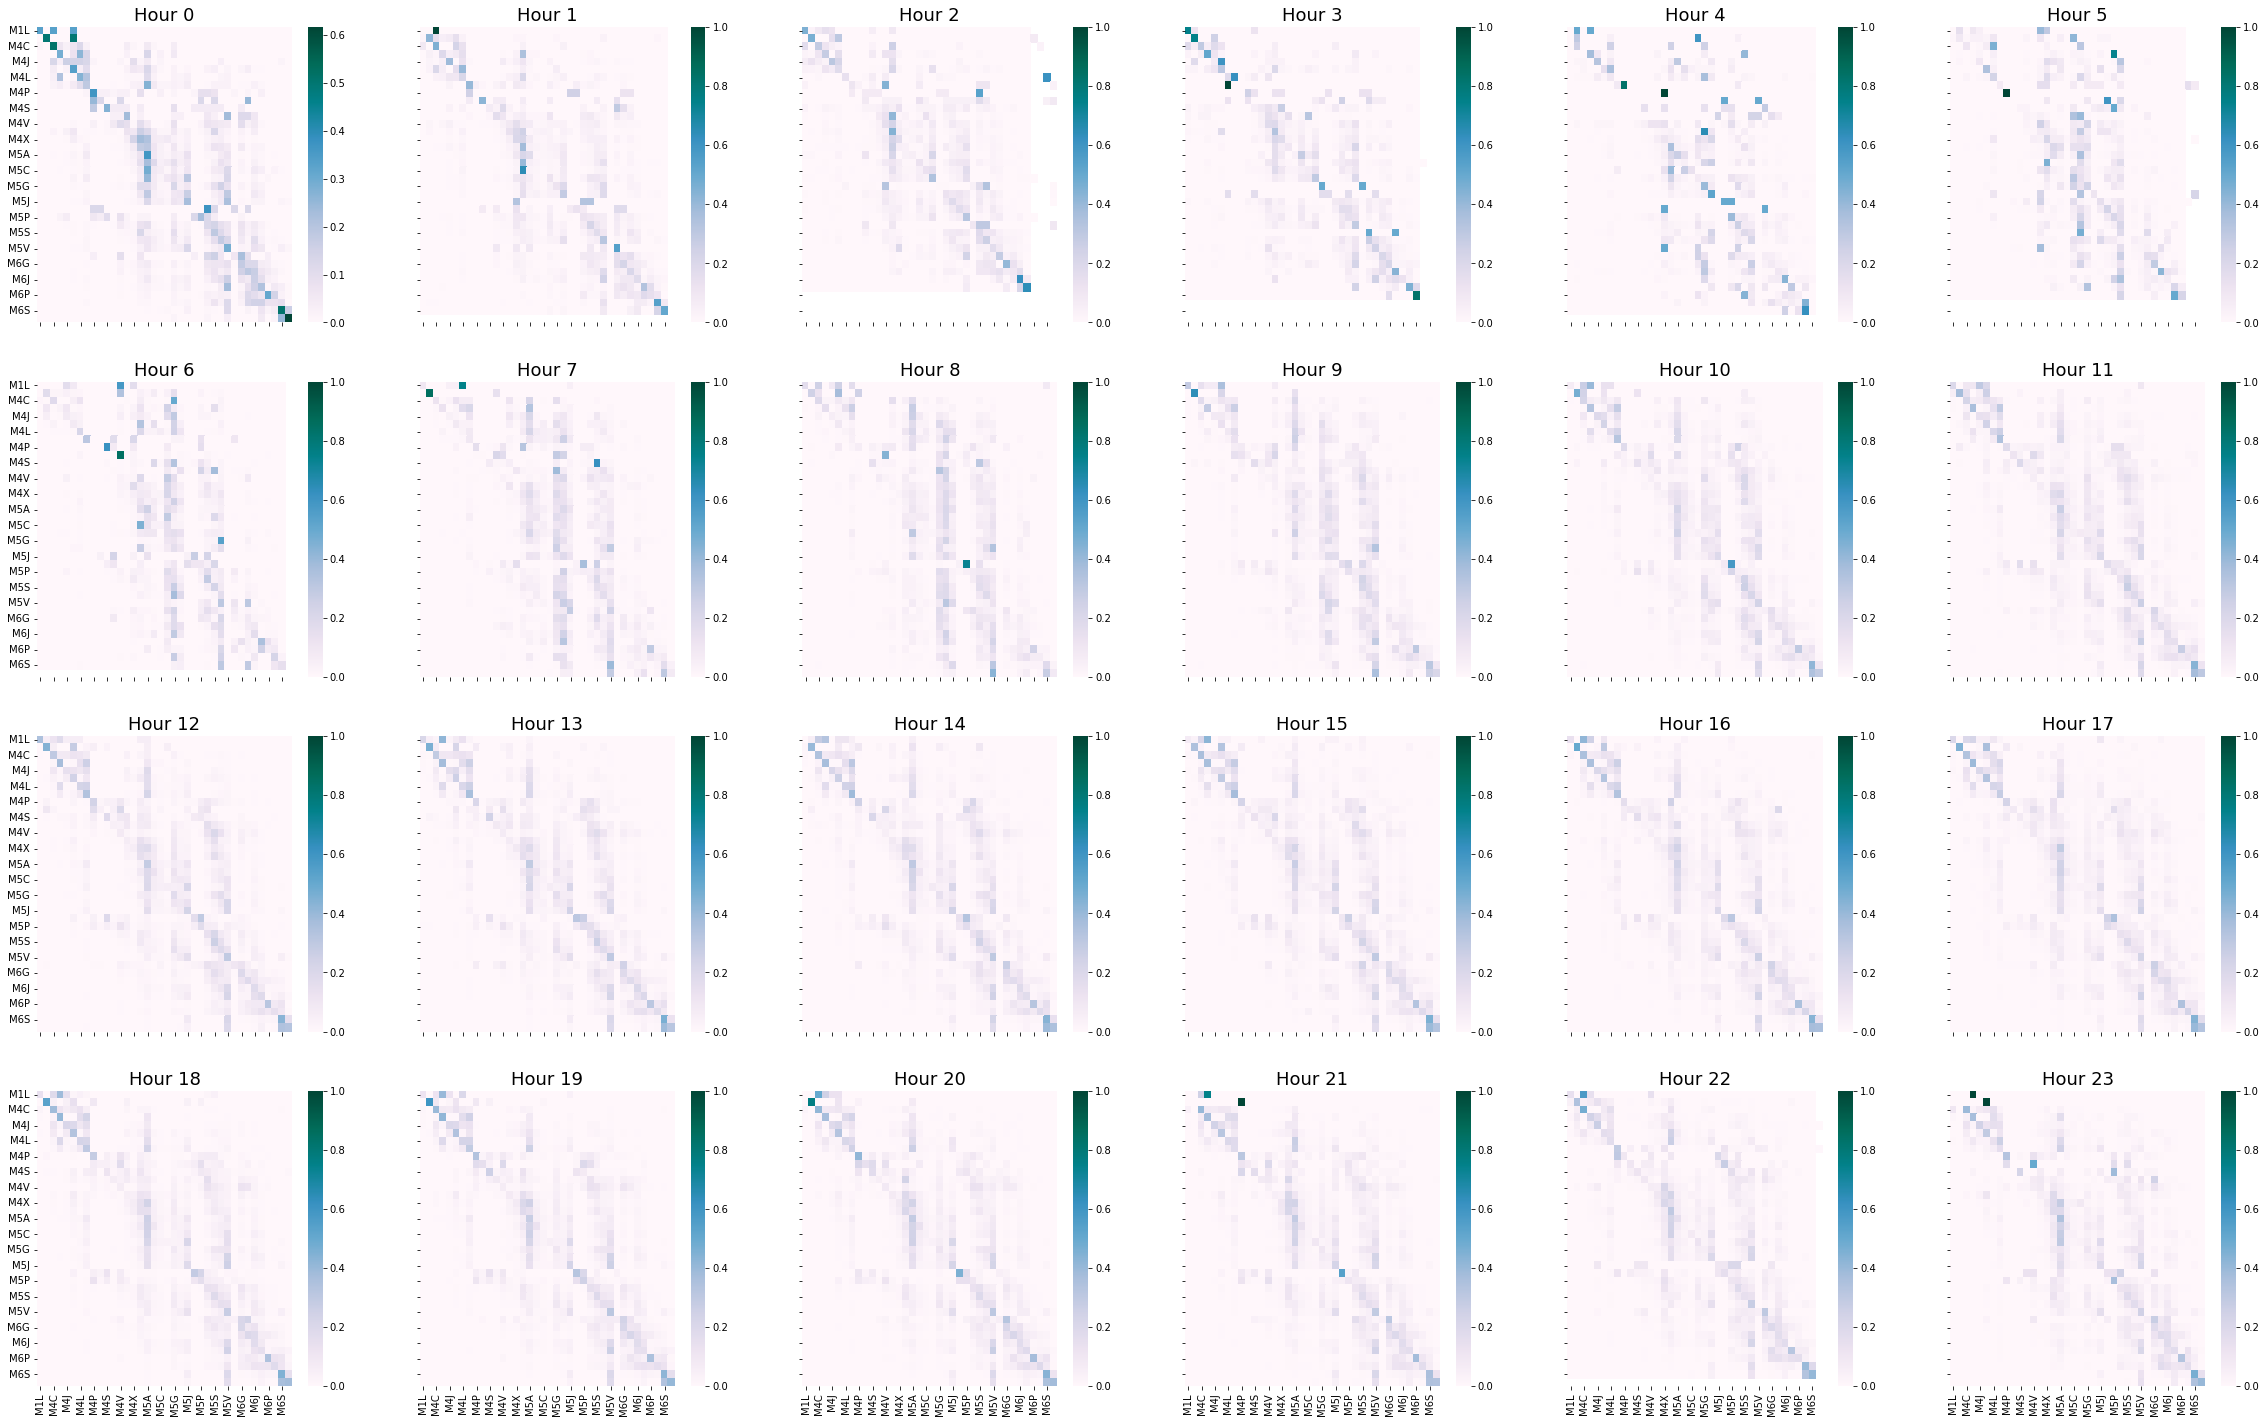

In [19]:
print('Forward Sortation Area_24_Hours')
heatmap_matrix_list = []
for i in range(24):
  hm = heatmap_hours_list[i]
  heatmap_matrix_list.append(compute_heatmap(hm, 'Forward_Sortation_Area', len(hm['Start Forward_Sortation_Area'].unique())))
# print('Max Value: ', heatmap_matrix.to_numpy().max())
# display(heatmap_matrix)
plot_24_heatmaps(heatmap_matrix_list, 'Forward_Sortation_Area_24_Hours')

In [17]:
heatmap_matrix

,M1L,M3C,M4C,M4E,M4J,M4K,M4L,M4M,M4P,M4R,...,M5V,M6C,M6G,M6H,M6J,M6K,M6P,M6R,M6S,M8V
M1L,0.142857,0.044643,0.258929,0.169643,0.107143,0.133929,0.053571,0.008929,0.000000,0.000000,...,0.008929,0.000000,0.000000,0.008929,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M3C,0.003817,0.423664,0.049618,0.000000,0.007634,0.270992,0.000000,0.011450,0.061069,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M4C,0.015213,0.002685,0.314989,0.076957,0.080984,0.143624,0.126174,0.080089,0.000000,0.000000,...,0.003132,0.000000,0.000447,0.000000,0.000895,0.000000,0.000447,0.000000,0.003132,0.000000
M4E,0.007582,0.000000,0.019635,0.377333,0.005832,0.011275,0.155521,0.260109,0.000000,0.000000,...,0.006221,0.000000,0.000583,0.000194,0.002722,0.001166,0.000000,0.000000,0.000583,0.000389
M4J,0.003564,0.001018,0.091141,0.013238,0.179735,0.169043,0.105906,0.155804,0.001527,0.000000,...,0.006619,0.000000,0.001527,0.000000,0.001018,0.001018,0.000000,0.000000,0.002037,0.000000
M4K,0.000267,0.007476,0.040315,0.006808,0.049927,0.285276,0.020558,0.107729,0.001468,0.000133,...,0.013349,0.000000,0.008143,0.002937,0.004939,0.001602,0.000400,0.000267,0.000801,0.000000
M4L,0.000738,0.000295,0.020517,0.141107,0.015793,0.015646,0.219631,0.238376,0.000148,0.000000,...,0.016384,0.000000,0.000886,0.000148,0.002362,0.001181,0.000295,0.000000,0.000295,0.000295
M4M,0.000040,0.000081,0.004751,0.067606,0.008818,0.025609,0.085645,0.365090,0.000121,0.000000,...,0.028951,0.000040,0.001248,0.000403,0.006000,0.003100,0.000040,0.000161,0.000966,0.000362
M4P,0.000000,0.026578,0.001661,0.003322,0.003322,0.026578,0.002492,0.015781,0.249169,0.025748,...,0.009967,0.012458,0.014120,0.004153,0.004153,0.002492,0.000831,0.000831,0.001661,0.000000
M4R,0.000000,0.013274,0.004425,0.000000,0.000000,0.013274,0.000000,0.000000,0.070796,0.097345,...,0.000000,0.004425,0.008850,0.017699,0.004425,0.000000,0.000000,0.004425,0.000000,0.000000


# 4.0 Download Files

In [ ]:
checkout_in_list = ['Checkout', 'Checkin']
day_of_week_list = ['Weekdays', 'Weekends_Holidays']
day_division_list = ['Morning Peak Hours', 'Day Hours', 'Evening Peak Hours', 'Night Hours']
# region_division_list = ['Dissemination_Area', 'Neighbourhood', 'Forward_Sortation_Area']
region_division_list = ['Dissemination_Area', 'Forward_Sortation_Area']
season_list = ['springfall', 'summer', 'winter']

# download map html files
# for c in checkout_in_list:
#   for region in region_division_list:
#     for dayofweek in day_of_week_list:
#       for day_div in day_division_list:
#         file_name = f'{region}-{c}_{dayofweek}_{day_div}.html'
#         print(file_name)
#         files.download(file_name)

# download heatmaps
for region in region_division_list:
  for season in season_list:
    file_name = f'{region}-{season}.png'
    print(file_name)
    files.download(file_name)

- Plot choropleth & heatmap for:
1. toronto neighbourhoods
2. FSAs
3. dissemination area

- Find definitions for these divisions
- Analyze any patterns in the data from looking at the geographic regions
- Produce a comprehensive EDA report


- Read clustering algorithm from paper + write in latex

In [ ]:
# DataFrames by weekday/weekend/holidays: df_weekday, df_weekend, df_holidays
# Test for one dataframe, group data by hour
df1, df2, df3, df4 = split_time_periods(df_weekday)
trip_counts = df1[['Trip Id', 'Neighbourhood']].groupby(by=['Neighbourhood']).count()
trip_counts.rename(columns={'Trip Id': 'Number of Trips'}, inplace=True)
trip_counts.reset_index(inplace=True)
print(trip_counts.shape)
trip_counts.head()

# trip_num_hour_annual, trip_num_hour_casual = split_into_annual_casual(trip_counts)